In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix
import math
import seaborn as sn
from scipy.stats import pearsonr

In [3]:
df = pd.read_csv("BTP Data-001/BTP Data/Process_Rainfall_Data/5Malappuram-Ponnani_processed.csv")

In [4]:
df

,Date,RF
0,1970-02-01,0.0
1,1970-02-02,0.0
2,1970-02-03,0.0
3,1970-02-04,0.0
4,1970-02-05,0.0
...,...,...
13135,2016-12-27,0.0
13136,2016-12-28,0.0
13137,2016-12-29,0.0
13138,2016-12-30,0.0


In [5]:
df = df.replace(-1.0,np.nan)

In [6]:
df

,Date,RF
0,1970-02-01,0.0
1,1970-02-02,0.0
2,1970-02-03,0.0
3,1970-02-04,0.0
4,1970-02-05,0.0
...,...,...
13135,2016-12-27,0.0
13136,2016-12-28,0.0
13137,2016-12-29,0.0
13138,2016-12-30,0.0


In [7]:
df = df.assign(RF=df.RF.interpolate(method='linear',limit_direction='both'))

In [8]:
df

,Date,RF
0,1970-02-01,0.0
1,1970-02-02,0.0
2,1970-02-03,0.0
3,1970-02-04,0.0
4,1970-02-05,0.0
...,...,...
13135,2016-12-27,0.0
13136,2016-12-28,0.0
13137,2016-12-29,0.0
13138,2016-12-30,0.0


In [9]:
df.isna().sum()

Date    0
RF      0
dtype: int64

In [10]:
tot_RF = []
latency = 7
dt = []
week = []
for i in range(0,len(df)-latency,latency):
    tot_RF.append(np.sum(df['RF'][i:i+latency]))
    dd = str(df['Date'][i])+ "~" + str(df['Date'][i+latency])
    dt.append(dd)

In [11]:
len(dt)

1877

In [12]:
data = tot_RF
U = [min(data) , max(data)]

In [13]:
data = (data-U[0])/(U[1] - U[0])
Data = (np.array(data))
Data = np.reshape(Data , (Data.shape[0],1))

slt1 = int(0.80*len(data))
slt2 = int(0.90*len(data))
Train = Data[:slt1]
Val = Data[slt1:slt2]
Test = Data[slt1:]
DT = dt[slt1:]

In [14]:
x_axis = [i+1 for i in range(len(data))]
x_tr = x_axis[:slt1]
x_val = x_axis[slt1:slt2]
x_tst = x_axis[slt2:]
al = (U[1] - U[0]) + U[0]

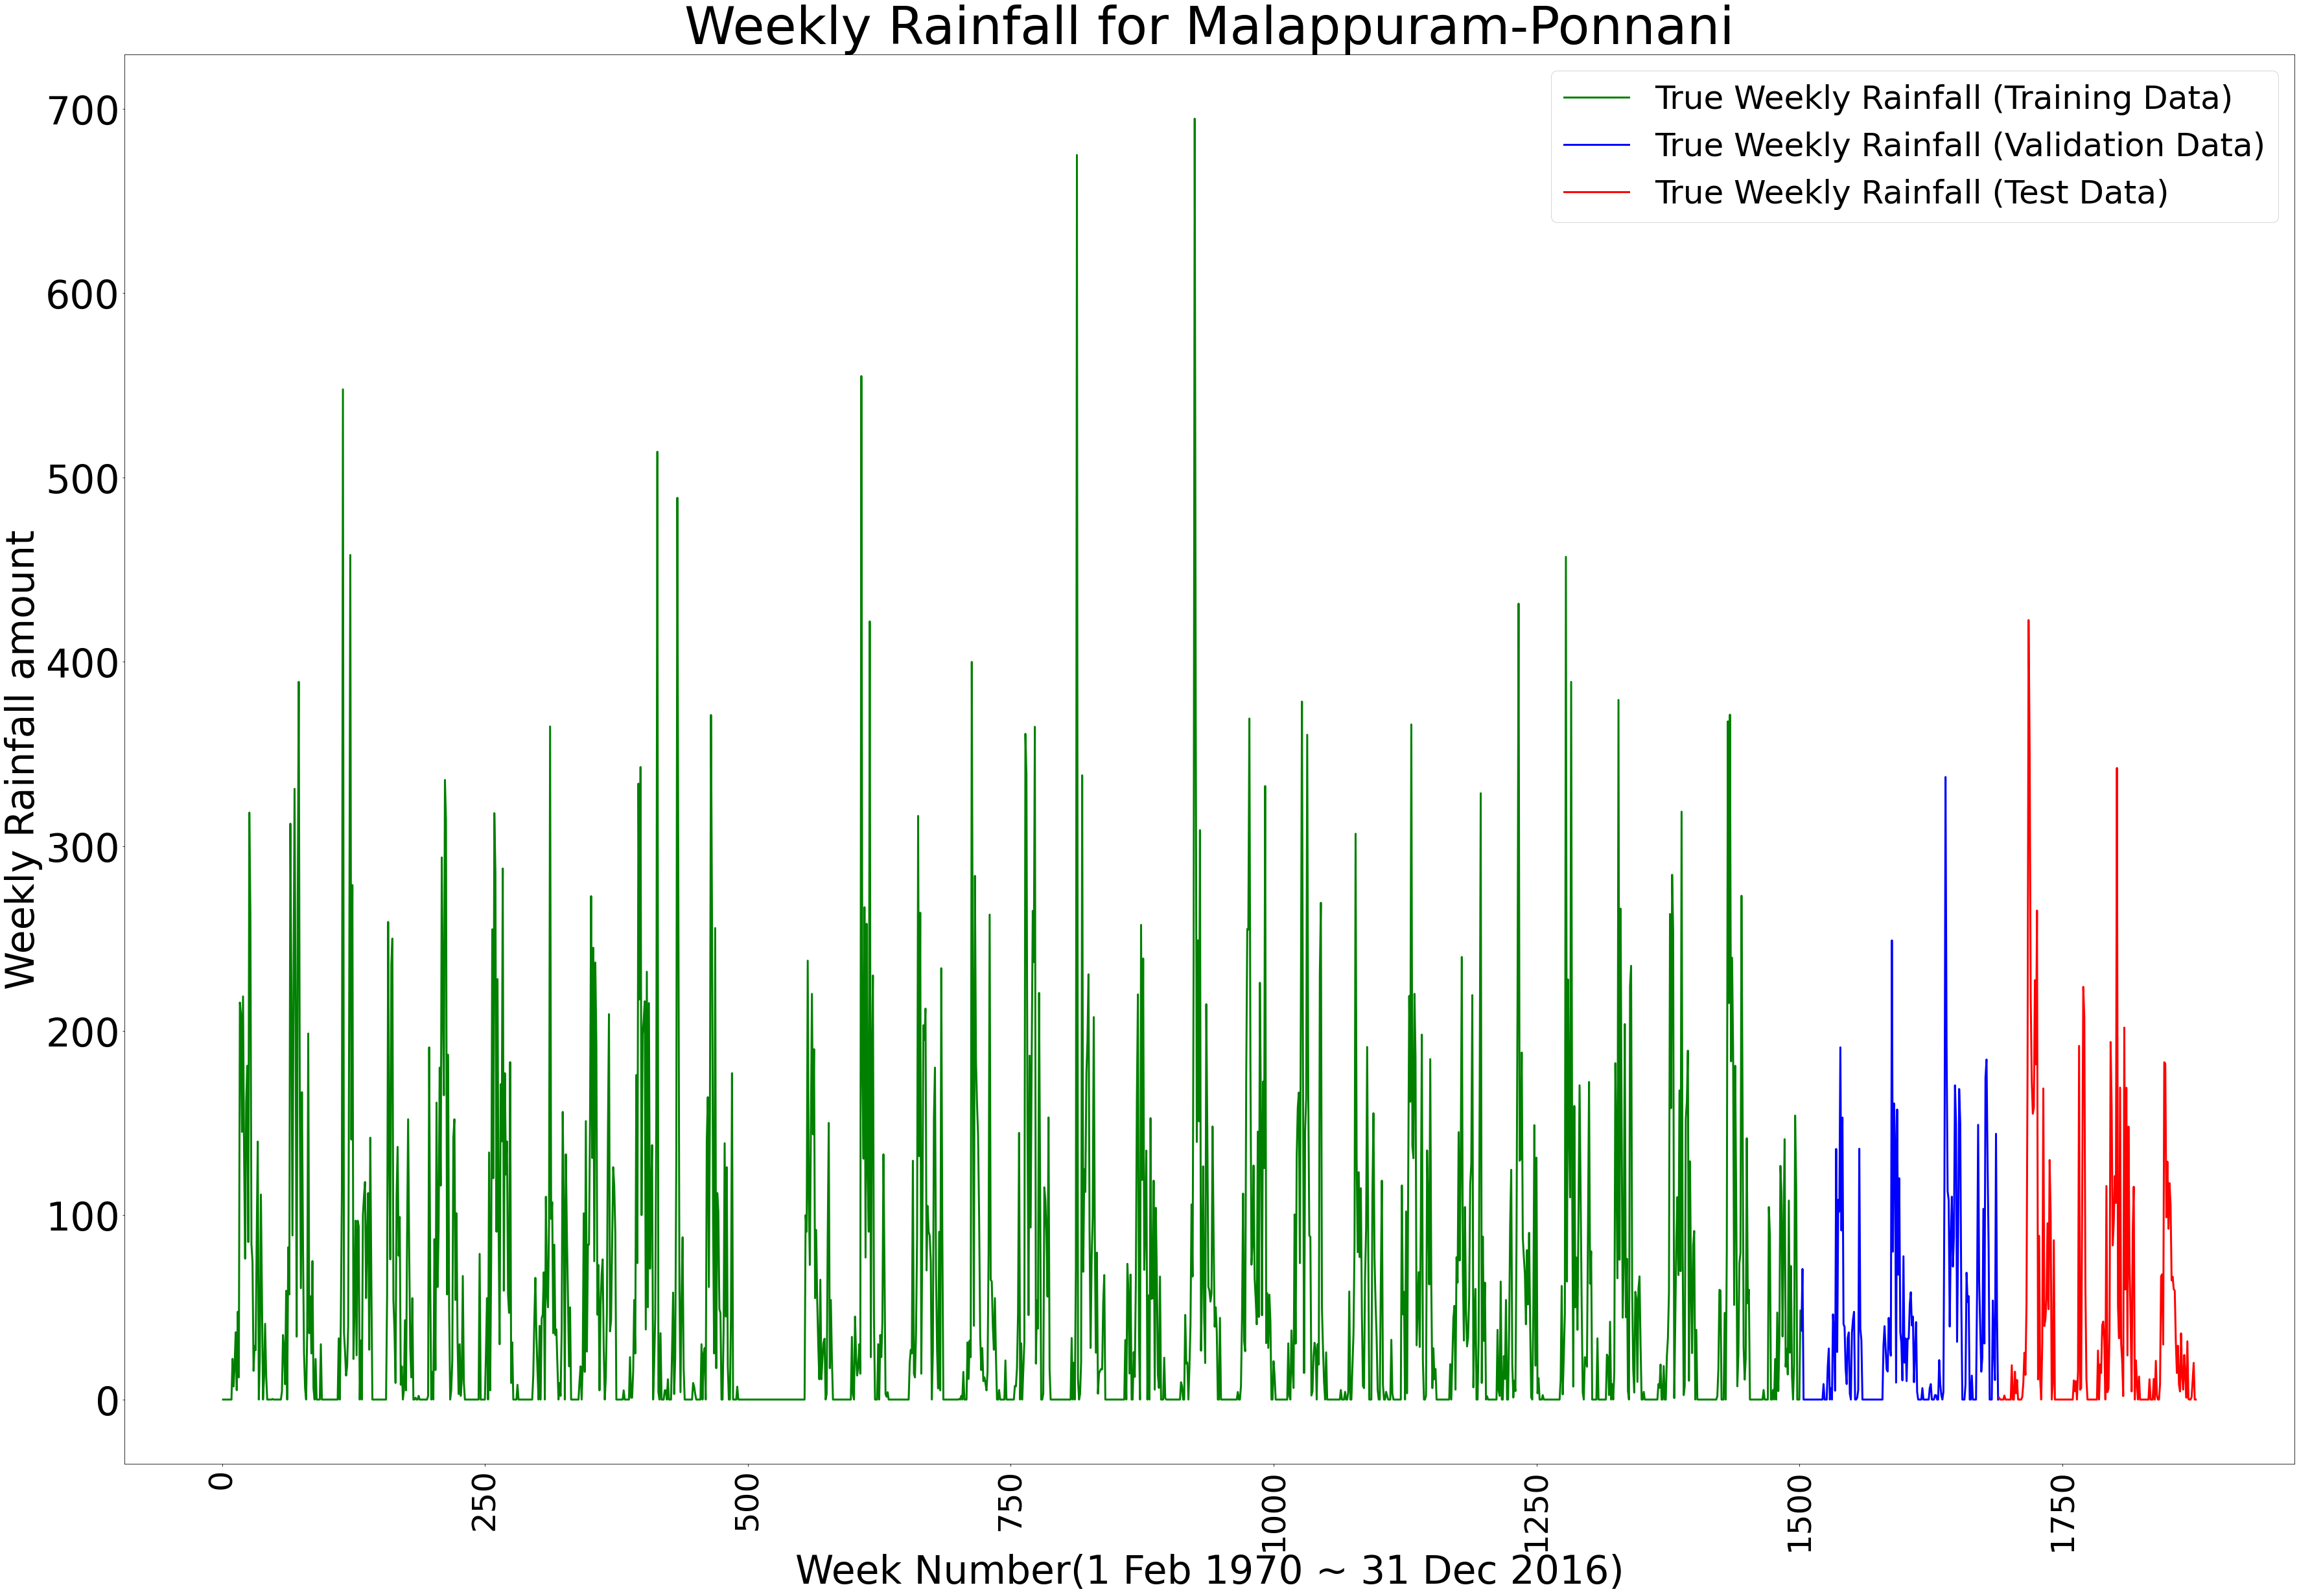

In [15]:
f = plt.figure() 
f.set_figwidth(60) 
f.set_figheight(40)
plt.title('Weekly Rainfall for Malappuram-Ponnani', fontsize = 80)
plt.xticks(fontsize=50, rotation=90)
plt.yticks(fontsize=60, rotation=0)
#plt.xticks(ticks,xaxis)
plt.ylabel('Weekly Rainfall amount',fontsize=60)
plt.xlabel('Week Number(1 Feb 1970 ~ 31 Dec 2016)',fontsize=60)
plt.plot(x_tr, Train*al, 'g',linestyle='-', linewidth='3', label = 'True Weekly Rainfall (Training Data)')
plt.plot(x_val, Val*al, 'b',linestyle='-', linewidth='3', label = 'True Weekly Rainfall (Validation Data)')
plt.plot(x_tst, Data[slt2:]*al, 'r',linestyle='-', linewidth='3', label = 'True Weekly Rainfall (Test Data)')
plt.legend(loc='best',prop={'size': 50})

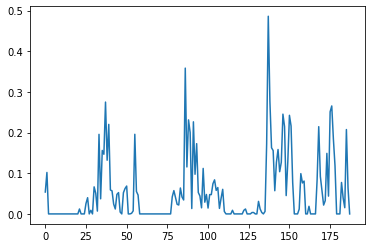

In [16]:
plt.plot(Val)

In [17]:
import GMM_K

numStates = 8
numMixtureComp = 2
dimension = 1
numIterations = 200
threshold = 0.0
covariance_type = 'full'
verbose = True


model = GMM_K.GmmHmmLikelihoodSimilarity_K(
    numStates=numStates,
    numMixtureComp=numMixtureComp,
    dimension=dimension,
    numIterations=numIterations,
    threshold=threshold,
    covariance_type=covariance_type,
    verbose = True
)

In [18]:
logValues = model.train([Train])

         1         420.7003             +nan
         2        1506.4123       +1085.7120
         3        1820.8499        +314.4376
         4        2112.5731        +291.7232
         5        2383.9886        +271.4155
         6        2640.8712        +256.8826
         7        2952.4721        +311.6009
         8        3355.9514        +403.4793
         9        3721.1551        +365.2037
        10        4135.5808        +414.4257
        11        4852.4976        +716.9168
        12        6249.2402       +1396.7427
        13        8613.5449       +2364.3047
        14      158107.6766     +149494.1316
        15        4703.9185     -153403.7581


Has model converged:  True


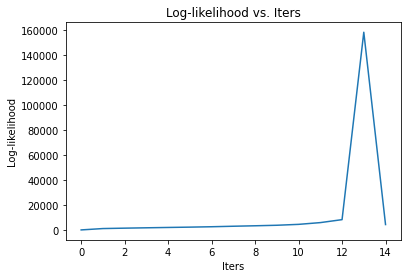

In [19]:
plt.plot(logValues, label='log-likelihood')
plt.xlabel('Iters')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood vs. Iters')
print('Has model converged: ', model.model.monitor_.converged)

In [ ]:
K = len(Train)
rmse = []
MAE = []
CC = []
for k in range(1,K):
    pred = model.predict(Val,k)
    p2 = pred*(U[1] - U[0]) + U[0]
    T1 = Val*(U[1] - U[0]) + U[0]
    rmse.append(mean_squared_error(p2, T1, squared=False))
    MAE.append(mae(T1,p2))
    d1 = np.array(T1)
    d1 = np.reshape(d1 , d1.shape[0])
    d2 = np.array(p2)
    d2 = np.reshape(d2 , d2.shape[0])
    corr, _ = pearsonr(d1, d2)
    CC.append(corr)
    print(k)

In [ ]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (50,10))
# ax1.set_xlim(1, K)
# ax1.set_xlabel('K', fontweight ='bold', fontsize = 30)
# ax1.set_ylabel('RMSE', fontweight ='bold', fontsize = 30)
# ax1.grid(True)
# ax1.set_title('RMSE vs K', fontsize = 30, fontweight ='bold')
# ax1.plot(rmse, linewidth='5')
# ax1.tick_params(axis='both', which='major', labelsize=30)


# ax2.set_xlim(1, K)
# ax2.set_xlabel('K', fontweight ='bold', fontsize = 30)
# ax2.set_ylabel('MAE', fontweight ='bold', fontsize = 30)
# ax2.grid(True)
# ax2.set_title('MAE vs K', fontsize = 30, fontweight ='bold')
# ax2.plot(MAE, linewidth='5')
# ax2.tick_params(axis='both', which='major', labelsize=30)

# ax3.set_xlim(1, K)
# ax3.set_xlabel('K', fontweight ='bold', fontsize = 30)
# ax3.set_ylabel('CC', fontweight ='bold', fontsize = 30)
# ax3.grid(True)
# ax3.set_title('CC vs K', fontsize = 30, fontweight ='bold')
# ax3.plot(CC, linewidth='5')
# ax3.tick_params(axis='both', which='major', labelsize=30)


In [ ]:
th = 115
st = 'K='+str(th)
f, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('K', fontweight ='bold', fontsize = 12)
ax.set_ylabel('RMSE', fontweight ='bold', fontsize = 12)
ax.set_title('RMSE vs K', fontsize = 12, fontweight ='bold')
ax.plot(rmse, '-' , label = 'RMSE value')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.plot([0, 0.7], [0, 0.7], transform=ax.transAxes, label = 'Diagonal Line')
ax.plot(th, rmse[th-1], 'go')
ax.axvline(x=th , ymax = 0.25,ls='--',c='black')
ax.text(th+20, rmse[th-1]-2, st, fontsize=12)
ax.legend()

In [20]:
pred = model.predict(Test,len(Train))
p2 = pred*(U[1] - U[0]) + U[0]
T1 = Test*(U[1] - U[0]) + U[0]

In [21]:
len(DT)

376

In [22]:
xaxis = [DT[i] for i in range(0,len(DT),10)]
ticks = [i+1 for i in range(0,len(DT),10)]

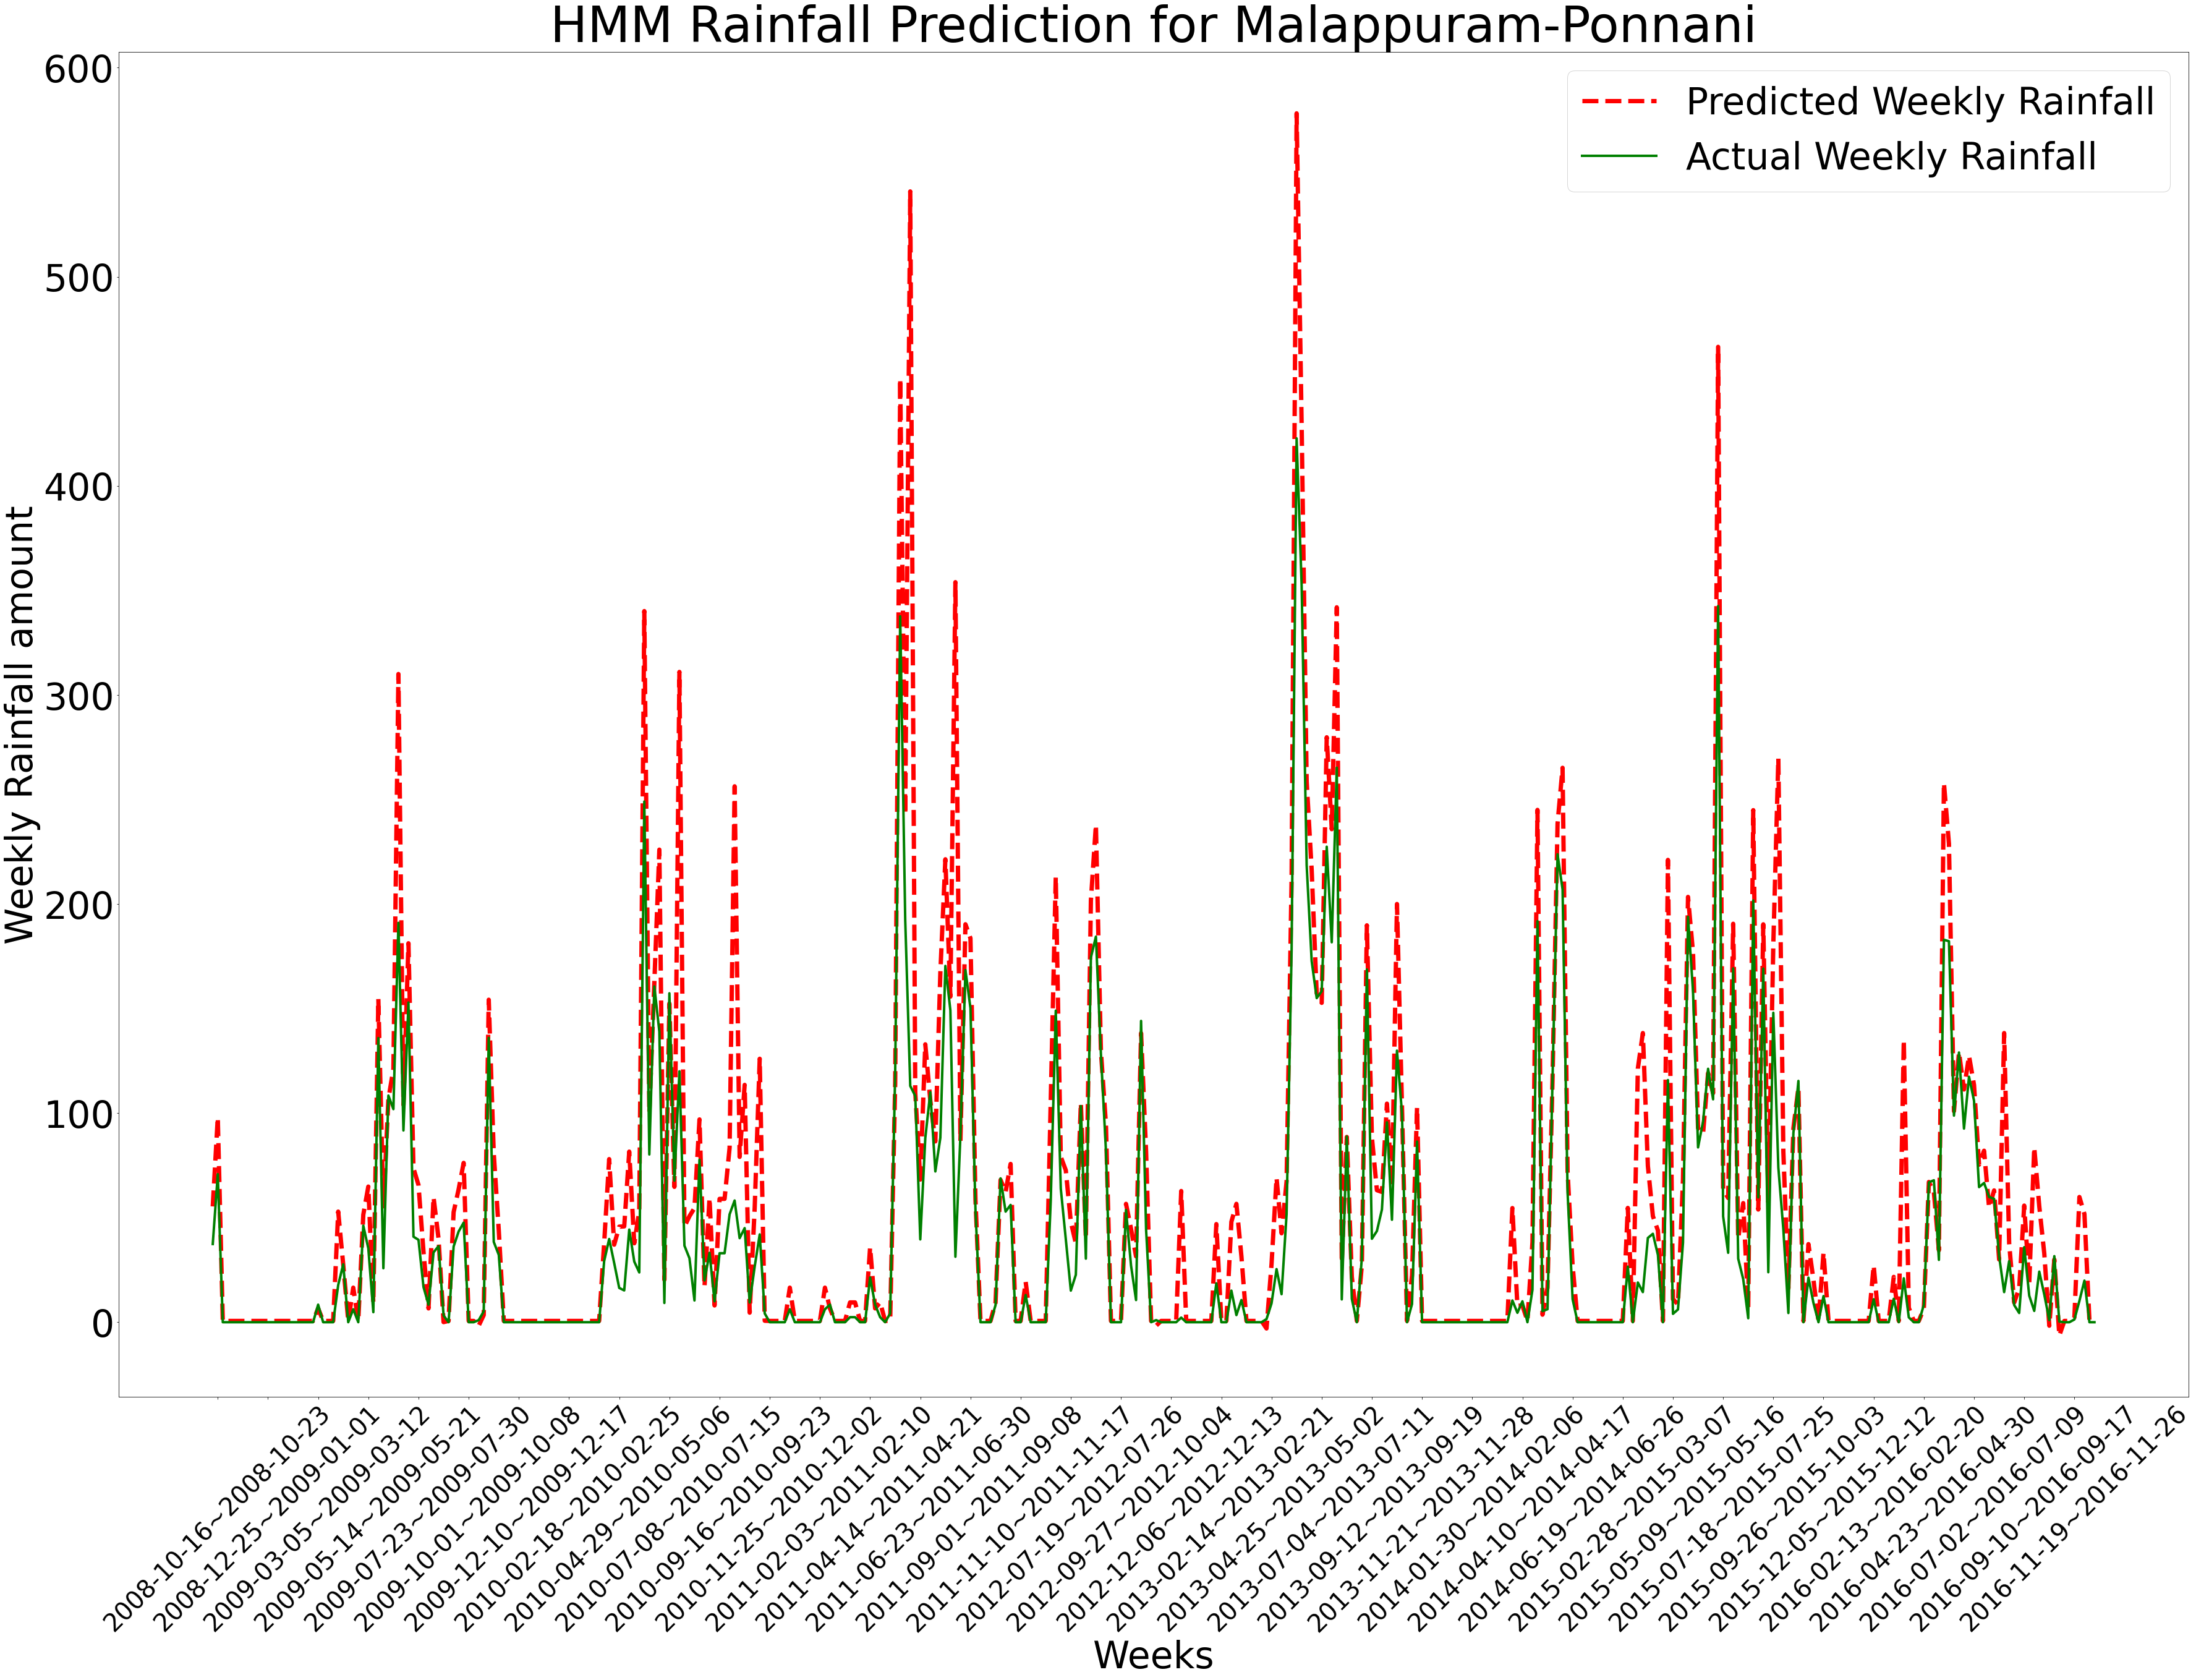

In [25]:
f = plt.figure() 
f.set_figwidth(60) 
f.set_figheight(40)
plt.title('HMM Rainfall Prediction for Malappuram-Ponnani', fontsize = 80)
plt.xticks(fontsize=40, rotation=45)
plt.yticks(fontsize=60, rotation=0)
plt.xticks(ticks,xaxis)
plt.ylabel('Weekly Rainfall amount',fontsize=60)
plt.xlabel('Weeks',fontsize=60)
plt.plot(p2-7, 'r', linestyle='--', linewidth='7', label = 'Predicted Weekly Rainfall')
plt.plot(T1, 'g',linestyle='-', linewidth='4', label = 'Actual Weekly Rainfall')
plt.legend(loc='best',prop={'size': 60})

In [29]:
mean_squared_error(T1, p2-7, squared=False)

43.36563374496232

In [30]:
mae(T1,p2-7)

18.384678573234947

In [31]:
d1 = np.array(T1)
d1 = np.reshape(d1 , d1.shape[0])
d2 = np.array(p2)
d2 = np.reshape(d2 , d2.shape[0])

corr, _ = pearsonr(d1, d2)
corr

0.9129359590144467